# Wprowadzenie

`Edycja wiedzy` (Knowledge-based Model Editing, KME) w dużych modelach językowych to proces precyzyjnej modyfikacji zachowania wstępnie wytrenowanych modeli, aby uwzględniały nowe informacje, przy jednoczesnym zachowaniu wiedzy niepowiązanej z edytowanymi treściami. Wymaga to wprowadzenia zmian w modelu w sposób ograniczony, by zapobiec wpływowi na inne obszary wiedzy.
- `Obiekt edycji`: Wiedza jest reprezentowana jako trójki wiedzy ( 𝑠, 𝑟, 𝑜 ), gdzie 𝑠 to podmiot, 𝑟 to relacja, a 𝑜 to obiekt. Celem jest aktualizacja starej wiedzy ( 𝑠, 𝑟, 𝑜 ) na nową ( 𝑠, 𝑟, 𝑜∗ )
- `Metryki oceny`:
    - Dokładność (Accuracy) - odsetek poprawnych odpowiedzi po edycji w odniesieniu do oczekiwanych wyników
    - Lokalność (Locality) - na ile model zachowuje niezmienione odpowiedzi dla danych spoza zakresu edycji
    - Generalizacja (Generality) - zdolność modelu do poprawnego reagowania na różnorodne zapytania semantycznie powiązane z edytowaną wiedzą
    - Przenośność (Portability) - zdolność modelu do przenoszenia wprowadzonych zmian na inne powiązane logicznie konteksty
    - Retencja (Retainability) - zdolność modelu do zachowania efektów wcześniejszych edycji przy kolejnych aktualizacjach
    - Skalowalność (Scalability) - zdolność modelu do jednoczesnego uwzględniania wielu edycji przy minimalnym spadku dokładności

`Causal-Tracing` to metoda analizy przyczynowej służąca do lokalizowania faktów przechowywanych w dużych modelach językowych. Technika ta pozwala zidentyfikować wewnętrzne stany ukryte, które są kluczowe dla prognozowania faktów.  
Przebieg:
- Uruchimienie eksperymentów:
    - `Clean Run` - model przetwarza poprawne dane wejściowe
    - `Corrupted Run` - model przetwarza dane wejściowe z zakłóconymi elementami podmiotu
    - `Restored Run` - wybrane ukryte stany są przywracane do ich oryginalnych wartości, aby ocenić ich wpływ na wynik
- Pomiar efektów:
    - `Efekt całkowity` (Total Effect, TE) - różnica między prawdopodobieństwem poprawnej odpowiedzi w przypadku czystych i zakłóconych danych wejściowych
    - `Efekt pośredni` (Indirect Effect, IE) - różnica w prawdopodobieństwie poprawnej odpowiedzi między zakłóconym a przywróconym stanem
  
Wnioski:  
Środkowe warstwy MLP (middle-layer MLP) mają kluczowe znaczenie dla przechowywania faktów i ich przywoływania

`Rank-One Model Editing` (ROME) to metoda edycji wiedzy w modelach językowych, która umożliwia modyfikację pojedynczych faktów przechowywanych w modelu poprzez bezpośrednią manipulację wagami w warstwach MLP.  
Przebieg:
- `Określenie klucza` ( 𝑘∗ ) - wybór reprezentacji kluczowej dla podmiotu ( 𝑠 ) na podstawie aktywacji w MLP na ostatnim tokenie podmiotu
- `Wyznaczenie wartości` ( 𝑣∗ ) - optymalizacja wartości 𝑣∗, aby zakodować nowy fakt ( 𝑠, 𝑟, 𝑜∗ ) z zachowaniem spójności modelu
- `Aktualizacja wag` - przeprowadzenie aktualizacji Rank-One w macierzy wag warstwy MLP ( 𝑊𝑝𝑟𝑜𝑗 ) w celu wprowadzenia nowego faktu

Wnioski:  
ROME powinno przewyższać inne metody (np. Fine-Tuning) pod względem zachowania ogólności (generalizacji) i specyficzności zmian konkretnych faktów

In [1]:
import pyvene as pv
import torch

In [2]:
import os
from copy import deepcopy

import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    theme,
    element_text,
    ggtitle,
    xlab, ylab, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## GPT2-XL

In [21]:
# init GPT2-XL model
config, tokenizer, gpt = pv.create_gpt2(name="gpt2-xl")
gpt.to(device)

loaded model


GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-47): 48 x GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=4800, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=1600)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=6400, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=6400)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
)

In [4]:
text = "The Space Needle is in downtown" 

In [5]:
def embed_to_distrib(model, embed, log=False, logits=False):
    if 'llama' in model.config.architectures[0].lower():
        with torch.inference_mode():
            vocab = torch.matmul(embed, model.lm_head.weight.T)
            if logits:
                return vocab
            return torch.nn.functional.log_softmax(vocab, dim=2) if log else torch.nn.functional.softmax(vocab, dim=2)
    else:
        vocab = pv.embed_to_distrib(model, embed, logits=logits)
        return vocab

# factual recall
def factual_recall(text, model, tokenizer):
    print(text)
    base = deepcopy(text)
    inputs = [
        tokenizer(base, return_tensors="pt").to(device),
    ]
    base = deepcopy(text)
    for i in range(len(inputs)):
        res = model(**inputs[i], output_hidden_states=True)
        last = res.last_hidden_state if hasattr(res, 'last_hidden_state') else res.hidden_states[-1]
        distrib = embed_to_distrib(model, last, logits=False)
        pv.top_vals(tokenizer, distrib[0][-1], n=10)

In [23]:
factual_recall(text, gpt, tokenizer) # correct answer is Seattle (doesn't work with GPT-2 :P)

The Space Needle is in downtown
_Seattle             0.9763796925544739
_Bellev              0.0027682853396981955
_Portland            0.0021577836014330387
,                    0.0015149434329941869
_Vancouver           0.0014351351419463754
_San                 0.00135757215321064
_Minneapolis         0.0009382683783769608
.                    0.0007443451904691756
_Tacoma              0.0006097276927903295
_Washington          0.0005885532009415329


In [6]:
# corrupted run - add Gaussian noise to embeddings of subject
class NoiseIntervention(pv.ConstantSourceIntervention, pv.LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(
            prng(1, 4, embed_dim)).to(device)
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None): 
        # source argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type):
    config = pv.IntervenableConfig(
        model_type=model_type,
        representations=[
            pv.RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=NoiseIntervention,
    )
    return config

In [7]:
def corrupted_recall(text, model, tokenizer, subject_pos):
    print(text)
    base = tokenizer(deepcopy(text), return_tensors="pt").to(device)
    config = corrupted_config(type(model))
    intervenable = pv.IntervenableModel(config, model)

    _, counterfactual_outputs = intervenable(
        base, unit_locations={"base": ([[subject_pos]])}
    )
    last = counterfactual_outputs.last_hidden_state if hasattr(counterfactual_outputs, 'last_hidden_state') else counterfactual_outputs.hidden_states[-1]
    distrib = embed_to_distrib(model, last, logits=False)
    pv.top_vals(tokenizer, distrib[0][-1], n=10)

In [8]:
def format_tokens(tokenizer, tokens):
    return [tokenizer.decode(tok).replace("\n", "\\n") for tok in tokens]

In [41]:
format_tokens(tokenizer, tokenizer(text)["input_ids"])

['The', ' Space', ' Need', 'le', ' is', ' in', ' downtown']

In [44]:
subject_pos = [0,1,2,3] # 'The', ' Space', ' Need', 'le'
corrupted_recall(text, gpt, tokenizer, subject_pos)

The Space Needle is in downtown
_Los                 0.032942548394203186
_San                 0.03194472938776016
_Seattle             0.026176458224654198
_Toronto             0.025859259068965912
_Chicago             0.02474905550479889
_Houston             0.02422424405813217
_Atlanta             0.018664496019482613
_Austin              0.017735304310917854
_St                  0.017606712877750397
_Denver              0.017408816143870354


In [9]:
# restored run - corrupt input in some position, then restore the hidden state at a particular layer for some positions
def restore_corrupted_with_interval_config(
        layer, 
        stream="mlp_activation", 
        window=10, 
        num_layers=48
    ):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = pv.IntervenableConfig(
        representations=[
            pv.RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            pv.RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[pv.VanillaIntervention]*(end-start),
    )
    return config

In [10]:
# corrupt all layers and positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer
def restored_run(text, text_token, model, tokenizer, subject_pos, save_path):
    base = tokenizer(deepcopy(text), return_tensors="pt").to(device)
    token = tokenizer.encode(deepcopy(text_token))[0]

    for stream in ["block_output", "mlp_activation", "attention_output"]:
        data = []
        n_layers = model.config.n_layer if hasattr(model.config, "n_layer") else model.config.num_hidden_layers
        for layer_i in tqdm(range(n_layers)):
            for pos_i in range(len(base.input_ids[0])):
                config = restore_corrupted_with_interval_config(
                    layer_i, stream, 
                    window=1 if stream == "block_output" else 10,
                    num_layers=n_layers,
                )
                n_restores = len(config.representations) - 1
                intervenable = pv.IntervenableModel(config, model)
                _, counterfactual_outputs = intervenable(
                    base,
                    [None] + [base]*n_restores,
                    {
                        "sources->base": (
                            [None] + [[[pos_i]]]*n_restores,
                            [[subject_pos]] + [[[pos_i]]]*n_restores,
                        )
                    },
                )
                last = counterfactual_outputs.last_hidden_state if hasattr(counterfactual_outputs, 'last_hidden_state') else counterfactual_outputs.hidden_states[-1]
                distrib = embed_to_distrib(
                    model, last, logits=False
                )
                prob = distrib[0][-1][token].detach().cpu().item()
                data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
        df = pd.DataFrame(data)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        df.to_csv(f"{save_path}/pyvene_rome_{stream}.csv")

In [20]:
token = " Seattle"
path = "./ex1/gpt2xl"
restored_run(text, token, gpt, tokenizer, subject_pos, path)

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [11]:
def plot_activations(text_token, labels, breaks, colors, titles, path):
    for stream in ["block_output", "mlp_activation", "attention_output"]:
        df = pd.read_csv(f"{path}/pyvene_rome_{stream}.csv")
        df["layer"] = df["layer"].astype(int)
        df["pos"] = df["pos"].astype(int)
        df["p(Seattle)"] = df["prob"].astype(float)

        plot = (
            ggplot(df, aes(x="layer", y="pos"))    

            + ggtitle(stream)
            + geom_tile(aes(fill=f"p({text_token.strip()})"))
            + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
            + scale_y_reverse(
                limits = (-0.5, 6.5), 
                breaks=breaks, labels=labels) 
            + theme(figure_size=(5, 4)) + ylab("") 
            + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
        )
        display(plot)

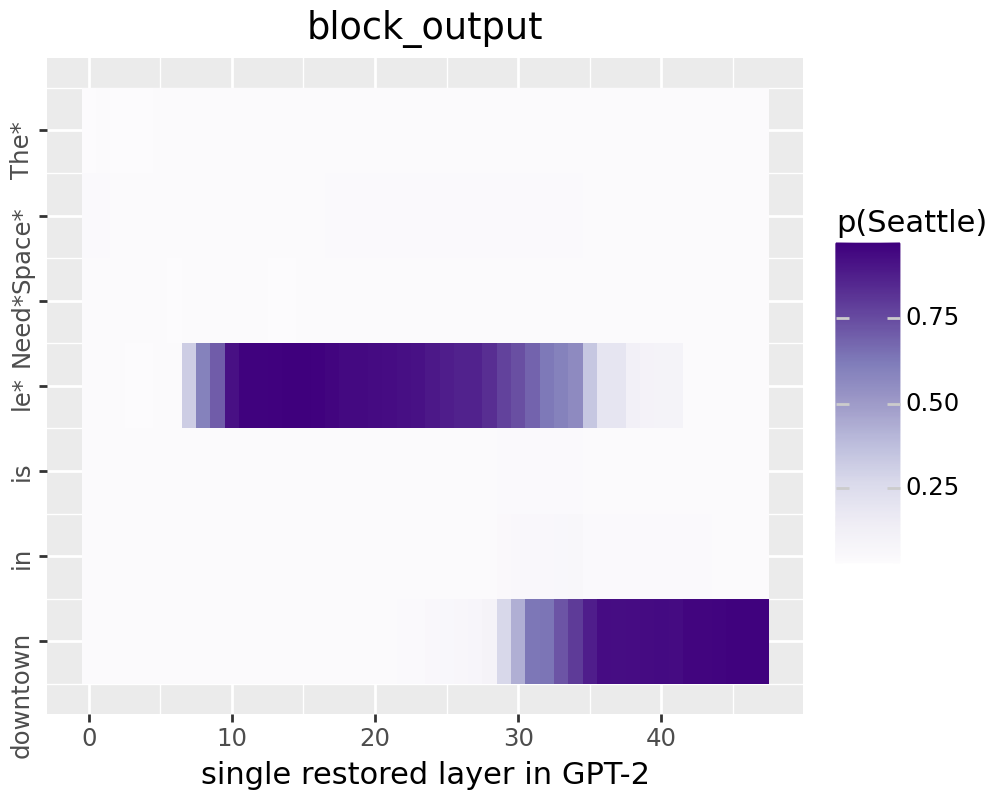

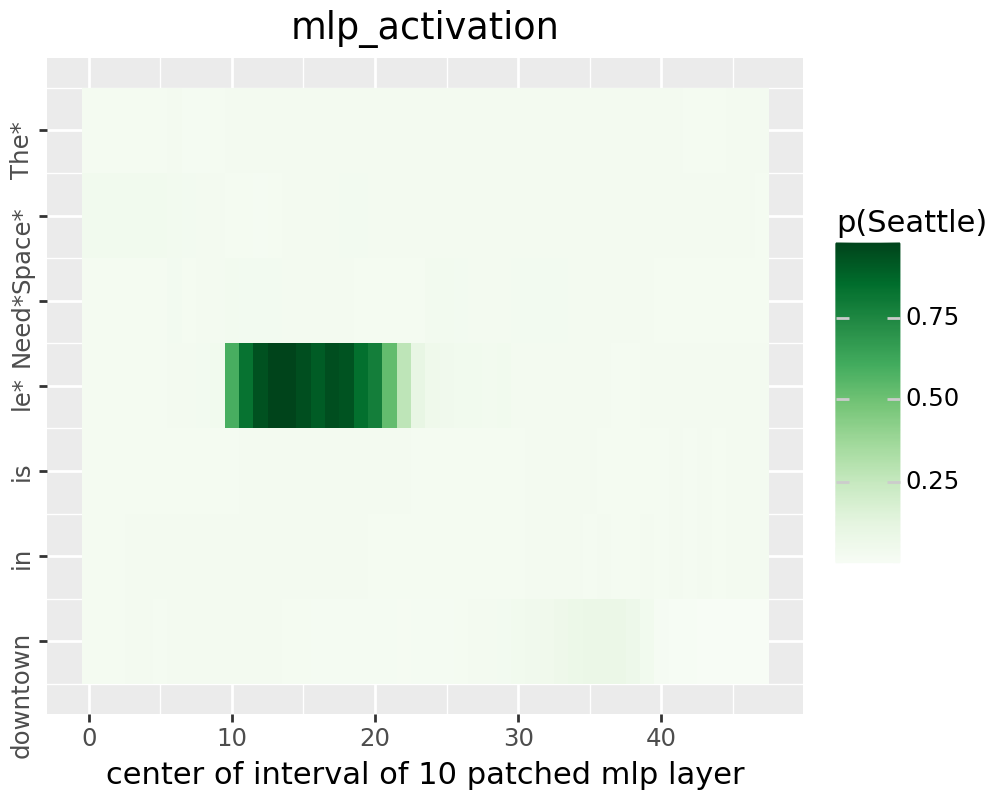

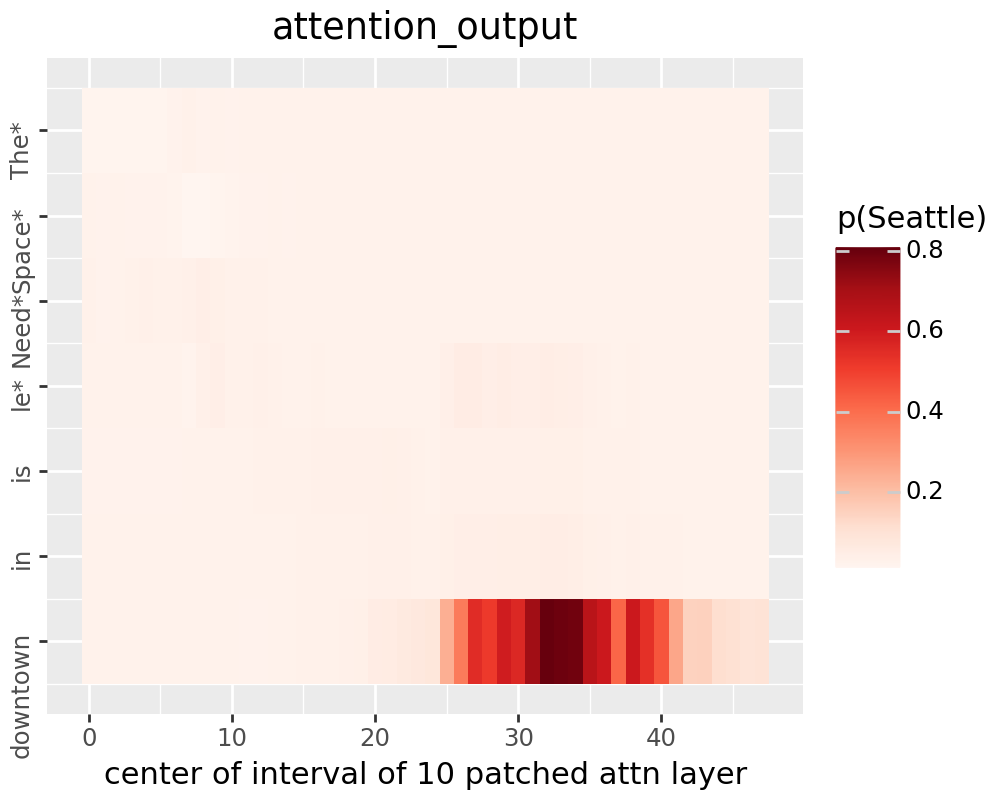

In [15]:
titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 
        
labels = ["The*", "Space*", "Need*", "le*", "is", "in", "downtown"]
breaks = [0, 1, 2, 3, 4, 5, 6]
plot_activations(token, labels, breaks, colors, titles, path)

In [46]:
torch.cuda.empty_cache()

## Llama 2

In [17]:
from dotenv import load_dotenv
load_dotenv()
hf_token = os.getenv("HUGGINGFACE_HUB_TOKEN")

from huggingface_hub import login
login(token=hf_token)

In [12]:
# init GPT-2 model
config, tokenizer, llama = pv.create_llama(name='openlm-research/open_llama_3b_v2')
llama.to(device);

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


loaded model


In [13]:
llama.config.output_hidden_states = True

In [14]:
factual_recall(text, llama, tokenizer)

The Space Needle is in downtown
Seattle              0.9765625
,                    0.006561279296875
.                    0.003997802734375
and                  0.00188446044921875
\n                   0.000888824462890625
at                   0.000888824462890625
in                   0.00054168701171875
on                   0.00041961669921875
se                   0.00041961669921875
Se                   0.00032806396484375


In [15]:
format_tokens(tokenizer, tokenizer(text)["input_ids"])

['<s>', 'The', 'Space', 'Need', 'le', 'is', 'in', 'downtown']

In [16]:
subject_pos = [1,2,3,4] # 'The', 'Space', 'Need', 'le'
corrupted_recall(text, llama, tokenizer, subject_pos)

The Space Needle is in downtown
.                    0.053955078125
,                    0.0198974609375
San                  0.0198974609375
Los                  0.0198974609375
Seattle              0.01202392578125
LA                   0.01202392578125
Detroit              0.01202392578125
Nashville            0.01202392578125
and                  0.01202392578125
Chicago              0.01202392578125


In [17]:
token = " Seattle"
path = "./ex1/llama2"
restored_run(text, token, llama, tokenizer, subject_pos, path)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 26 rows containing missing values.


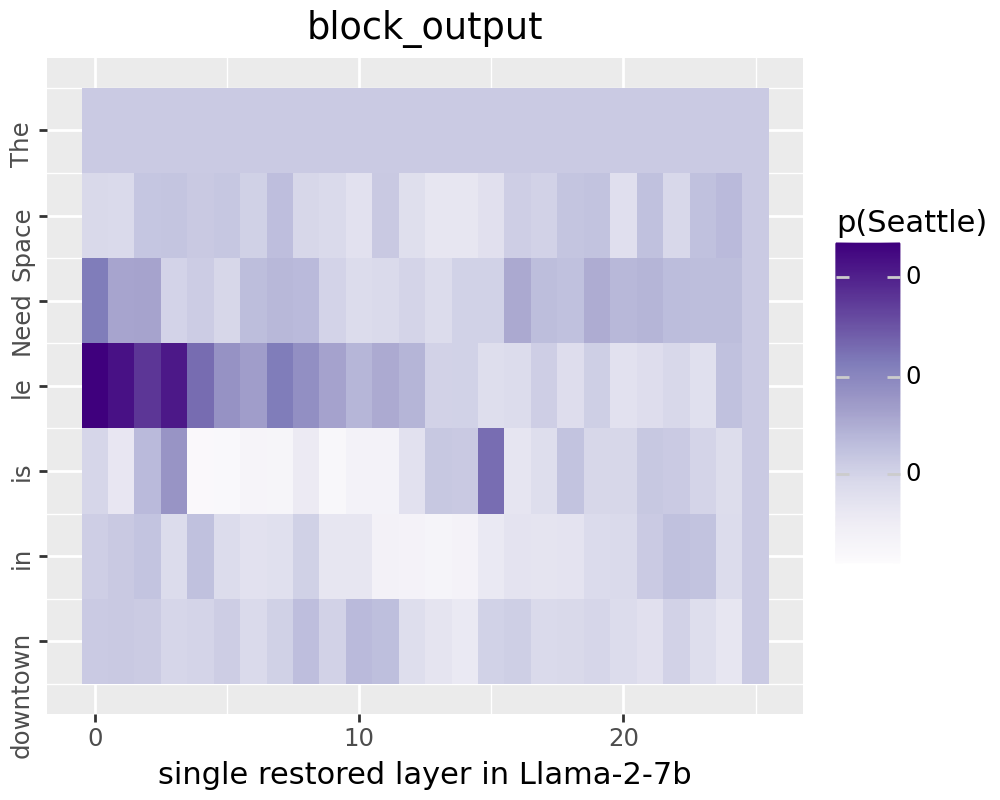

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 26 rows containing missing values.


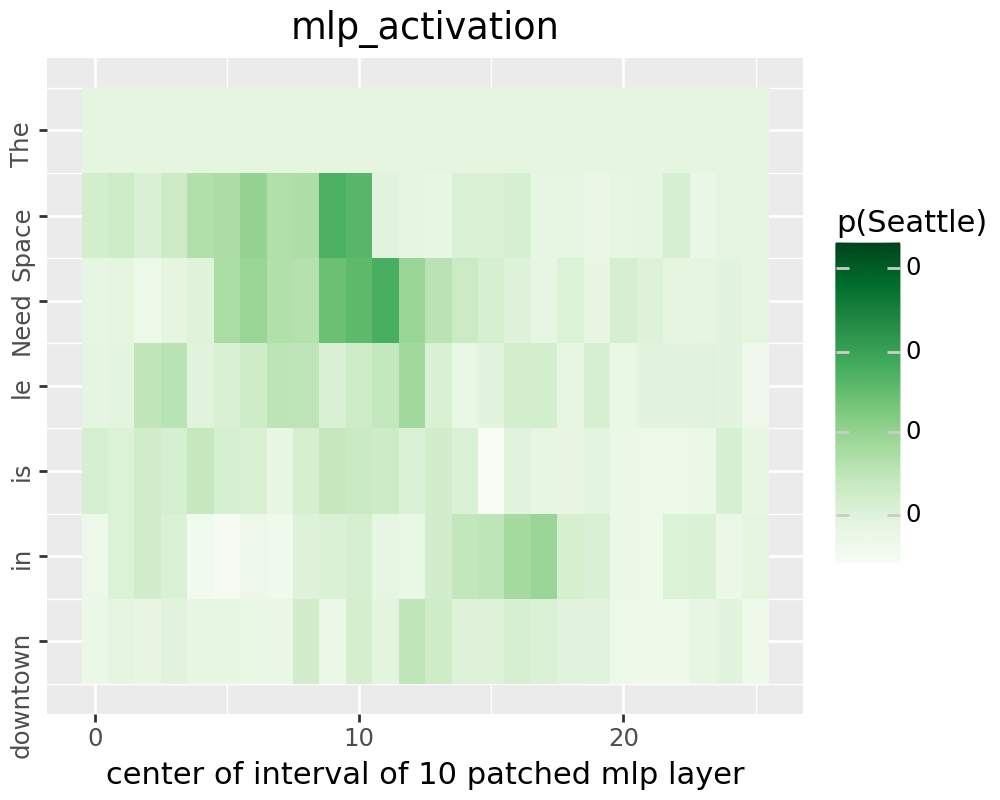

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 26 rows containing missing values.


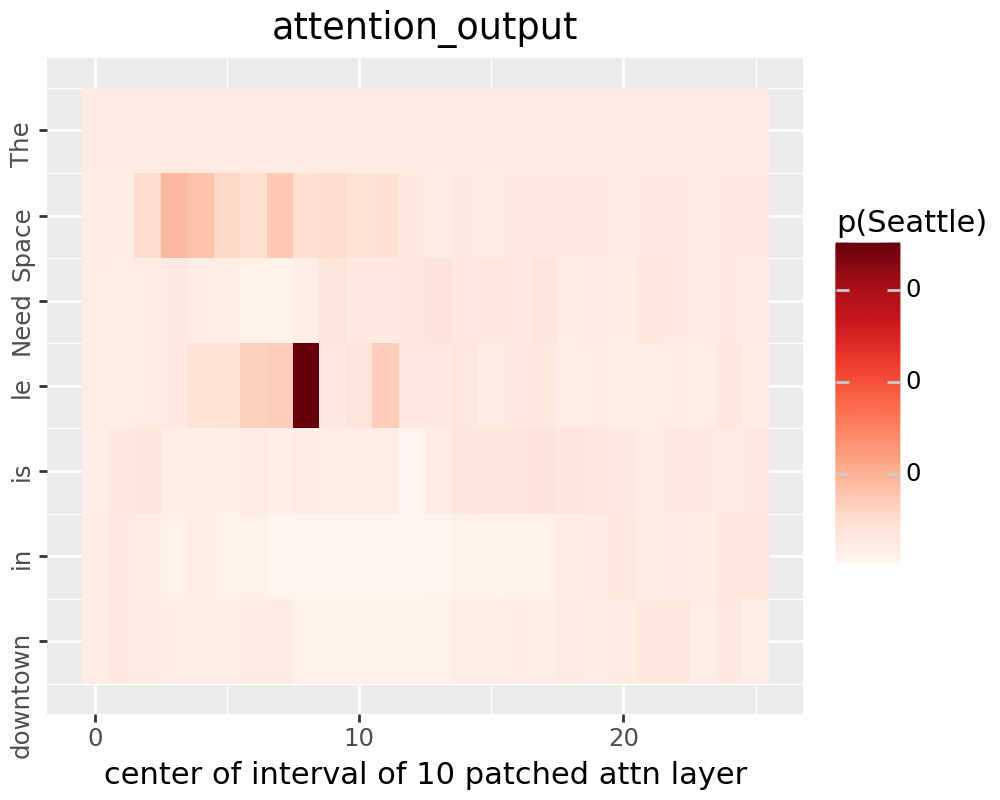

In [18]:
titles={
    "block_output": "single restored layer in Llama-2-7b",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 
        
labels = ["The", "Space", "Need", "le", "is", "in", "downtown"]
breaks = [0, 1, 2, 3, 4, 5, 6]
plot_activations(token, labels, breaks, colors, titles, path)

Wzorce aktywacji różnią się między tymi komponentami, ponieważ pełnią one różne role:
- `Attention Output`: Skupia się na tokenach, które mają największe znaczenie w określonym kontekście zdania oraz ich interakcjach
- `MLP Activation`: Bardziej lokalny i skoncentrowany na specyficznych tokenach (np. końcowe tokeny podmiotu), które są kluczowe dla enkapsulacji faktów
- `Block Output`: Agreguje informacje z uwagi i MLP, reprezentuje ogólne znaczenie informacji w warstwie